<a href="https://colab.research.google.com/github/ayarii/learner-engagement/blob/main/learner_'s_engagement_3_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Import data from Google Drive**

In [1]:
import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import datetime
from tensorflow import keras
from tensorflow.keras.models import Model
import tensorflow as tf
import pathlib
import os
import zipfile
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard
from keras.utils import to_categorical



In [2]:
#Import dataset
data_dir = tf.keras.utils.get_file(
    "dataset.zip",
    "https://github.com/ayarii/learner-engagement/blob/main/Student-engagement-dataset.zip?raw=true",
    extract=False)
with zipfile.ZipFile(data_dir, 'r') as zip_ref:
    zip_ref.extractall('/content/datasets')
data_dir = pathlib.Path('/content/datasets/Student-engagement-dataset')
print(data_dir)
print(os.path.abspath(data_dir))

40069772/40069772 [==============================] - 0s 0us/step
/content/datasets/Student-engagement-dataset
/content/datasets/Student-engagement-dataset


In [3]:
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

2120


Populating the interactive namespace from numpy and matplotlib
Shape of the image (21216,)


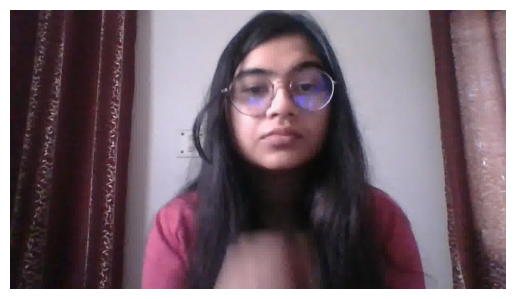

Shape of the image (14893,)


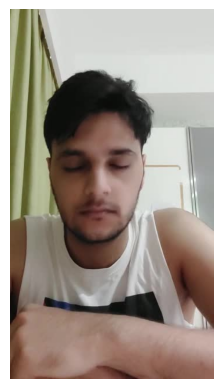

In [4]:
%pylab inline

url_engaged = r'https://github.com/ayarii/learner-engagement/blob/main/0076.jpg?raw=true'
resp = requests.get(url_engaged, stream=True).raw
image_array_engagement = np.asarray(bytearray(resp.read()), dtype="uint8")
print(f'Shape of the image {image_array_engagement.shape}')
image_engagement = cv2.imdecode(image_array_engagement, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_engagement, cv2.COLOR_BGR2RGB))
plt.show()

url_notEngaged = r'https://github.com/ayarii/learner-engagement/blob/main/0025.jpg?raw=true'
resp = requests.get(url_notEngaged, stream=True).raw
image_array_notEngaged = np.asarray(bytearray(resp.read()), dtype="uint8")
print(f'Shape of the image {image_array_notEngaged.shape}')
image_notEngaged = cv2.imdecode(image_array_notEngaged, cv2.IMREAD_COLOR)
plt.axis('off')
plt.imshow(cv2.cvtColor(image_notEngaged, cv2.COLOR_BGR2RGB))
plt.show()


In [5]:
batch_size = 3
img_height = 200
img_width = 200
train_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  )

val_data = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = val_data.class_names
print(class_names)

Found 2120 files belonging to 6 classes.
Using 1696 files for training.
Found 2120 files belonging to 6 classes.
Using 424 files for validation.
['Looking Away', 'bored', 'confused', 'drowsy', 'engaged', 'frustrated']


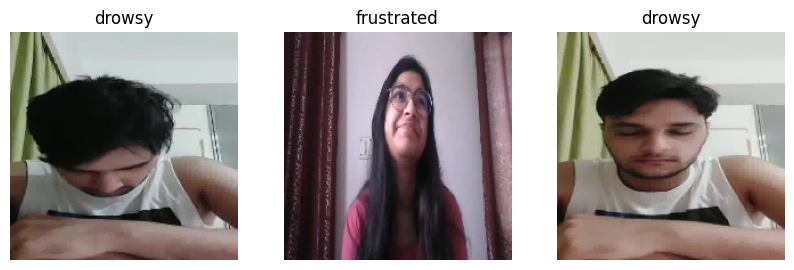

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
  for i in range(3):
    ax = plt.subplot(1, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
# Define the CNN model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(200, 200, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(6))
model.add(Activation('softmax'))


import numpy as np


# Assuming you've already defined and loaded your train_data and val_data
class_names = train_data.class_names  # or val_data.class_names

# Create a dictionary mapping class names to numeric labels
class_to_label = {class_name: i for i, class_name in enumerate(class_names)}

# Now, you can extract the labels from the dataset
train_labels = []
for images, labels in train_data:
    # Convert class names to numeric labels
    numeric_labels = [class_to_label[class_name] for class_name in labels.numpy()]
    train_labels.extend(numeric_labels)

# Repeat the similar code for val_data

# Convert lists to NumPy arrays
train_labels = np.array(train_labels)
#val_labels = np.array(val_labels)

# Set up callbacks
log_dir = "logs/"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[tensorboard_callback, early_stopping],
    y=train_labels_one_hot,  # Use the one-hot encoded labels
    validation_y=val_labels_one_hot
)

# Evaluate the model
loss, accuracy = model.evaluate(val_data, verbose=0)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')

KeyError: ignored

In [ ]:
model.summary()

In [ ]:
# Cette ligne importe la bibliothèque "files" de Google Colab, qui permet de charger des fichiers depuis votre ordinateur vers l'environnement Colab.
from google.colab import files
# Cette ligne demande à l'utilisateur de télécharger un fichier (une image dans ce cas) vers l'environnement Colab. Le fichier téléchargé sera stocké dans la variable file_to_predict.
file_to_predict = files.upload()
# Cette ligne itère sur les fichiers téléchargés (dans le cas où plusieurs fichiers auraient été téléchargés) et effectue les étapes suivantes pour chaque fichier.
for file_ in file_to_predict:
  #Cette ligne utilise la fonction cv2.imread de la bibliothèque OpenCV pour lire l'image téléchargée à partir du fichier.
  #L'image est stockée dans la variable image_to_predict.
    image_to_predict = cv2.imread(file_,cv2.IMREAD_COLOR)
    #Cette ligne affiche l'image en utilisant plt.imshow de la bibliothèque matplotlib.
    #cv2.cvtColor est utilisé pour convertir l'image du format BGR (utilisé par OpenCV) en format RGB (utilisé par matplotlib).
    plt.imshow(cv2.cvtColor(image_to_predict, cv2.COLOR_BGR2RGB))
    plt.show()
    #Cette ligne redimensionne l'image à une taille de 200x200 pixels à l'aide de cv2.resize et l'expands en ajoutant une dimension supplémentaire à l'aide de np.expand_dims.
    #Cela est nécessaire pour que l'image corresponde à la forme attendue par le modèle (une seule image avec les dimensions spécifiées).
    img_to_predict = np.expand_dims(cv2.resize(image_to_predict,(200,200)), axis=0)
    #Cette ligne effectue la prédiction en utilisant le modèle CNN entraîné (model.predict). La variable res contient les résultats de la prédiction.
    res = model.predict(img_to_predict)
predicted_class = np.argmax(res)  # Obtient l'indice de la classe prédite avec la plus haute probabilité
if predicted_class == 0:
    plt.imshow(cv2.cvtColor(image_engagement, cv2.COLOR_BGR2RGB))
    plt.show()
    print("Learner Engaged!")
elif predicted_class == 1:
    plt.imshow(cv2.cvtColor(image_notEngaged, cv2.COLOR_BGR2RGB))
    plt.show()
    print("Learner Not engaged!")
#Ce code permet de charger une image, de faire des prédictions avec le modèle CNN et d'afficher une image correspondant

In [ ]:
from sklearn.metrics import roc_curve, auc

# Collecte des prédictions du modèle pour les exemples de test
predictions = model.predict(img_to_predict)
print(predictions)
# Extraction des probabilités des classes positives (classe d'intérêt)
positive_probs = predictions[:, 1]
print(positive_probs)
# Obtention des étiquettes réelles des exemples de test
labels = np.array([1])
print(labels)
# Calcul des taux de faux positifs et de vrais positifs
fpr, tpr, thresholds = roc_curve(labels, positive_probs)

# Calcul de l'AUC (Area Under the Curve)
auc_score = auc(fpr, tpr)

# Tracé de la courbe ROC
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # Ligne diagonale en pointillés représentant une performance aléatoire
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()